____

# <font color=#FFAA11> Two-Temperature Model </font>

The TTM considered here is given by
$$\begin{align}
c_e \frac{\partial T_e}{\partial t} &= \frac{1}{r}\frac{\partial}{\partial r}\left(r k_e \frac{\partial T_e}{\partial r}\right) - \gamma (T_e - T_i), \\
c_i\frac{\partial T_i}{\partial t} &= \frac{1}{r}\frac{\partial}{\partial r}\left(r k_i \frac{\partial T_i}{\partial r}\right) + \gamma (T_e - T_i),
\end{align}
$$

which assumes a cylindrical plasma composed of electrons and ions with no mass flow. There are two important things to do:
1. put these equations into a form we want to use
  * definitions/symbols 
  * spatially varying conductivities
  * make these choices consistent with the slides
2. check the code very carefully to be sure it is consistent with the form of the equations in the chosen coordinate system. 

Feel free to copy this notebook to make versions to experiment with; put your version information at the bottom of this cell. In terms of the model and its parameters, a good place to start is with the paper:
<font color=#5588FF>
* Improved Two-Temperature Model and Its Application in Ultrashort Laser Heating of Metal Films
  * Lan Jiang and Hai-Lung Tsai
  * _Journal of Heat Transfer_ **127**, 1167 (2005)
  </font>


This is a toy code just for the purposes of getting started. Three main areas where major improvements are needed:
1. physical predictions for the parameters:
  * specific heats,
  * temperature relaxation rate,
  * thermal conductivity,
2. density profiles $\left. n_j(\rho)\right|_{ j=\{e, i\}}$ used by the parameters,
3. units,
4. steady improvement of the numerical methods.

Nicer visualizations, including animations, would be nice to have in the long run.



To keep track of versions:
* <font color=#22EE55> Murillo, 28 April 2023 </font>
* <font color=#AD1E21> Johnson, 2 May 2023 </font>

In [1]:
import numpy as np
import matplotlib.pyplot as plt
prop_cycle = plt.rcParams['axes.prop_cycle']
colors = prop_cycle.by_key()['color']

π = np.pi
m_p = 1.67e-27  # Ion mass (proton mass) [kg]
m_e = 9.1093837e-31  # Ion mass (proton mass) [kg]
e = 1.6e-19  # Elementary charge [C]
ε_0 = 8.85e-12  # Vacuum permittivity [F/m]
k_B = 1.38e-23  # Boltzmann constant [J/K]
hbar=  6.62607015e-34 # Planck 

#Gradient Function
def grad_T(T): #Gradient at boundaries. Neumann at 0, cylinder axis. 
    grad_T   = (T - np.roll(T,1))/dr
    grad_T[0]=0 
    return grad_T

In [2]:
###  Geometry Parameters ##

r_max = 200e-6  # Maximum radial distance [m]
σ = 25e-6      # [m] gaussian width of laser beam 
n = 101        # Number of grid points

# Discretize spatial domain, all [m]
r = np.linspace(0, r_max, n) #[m]
dr = r[1] - r[0]
cell_centers = r[:-1] + 0.5 * dr
cell_volumes = 2*π*(r[1:]**2 - r[:-1]**2)

In [3]:
# Physics
Z, A = 1.0, 40 # Argon
# Z, A = 1.0, 131 # Xenon

n_i = 6e26  # Electron density [m^-3]
n_e = n_i*Z  # Electron density [m^-3]
m_i = A*m_p   
rs  = (3/(4*π*n_i))**(1/3)

# Temperatures
Te_init = 18000# Te_in_eV * e / k_B  # Electron temperature [K]
Ti_init =  3300 #Ti_in_eV * e / k_B  # Ion temperature [K]

Te = Te_init*np.exp(-r**2/(2*σ**2)) #Gaussian Laser
Ti = Ti_init*np.exp(-r**2/(2*σ**2))

# Check Parameters
EF = hbar**2/(2*m_e) * (3*π**2 * n_e)**(2/3)

θ  = k_B *Te_init / EF
Γi = (Z*e)**2/(4*π*ε_0*rs)/(k_B*Ti_init)
Γe =     e**2/(4*π*ε_0*rs)/(k_B*Te_init)

print("Physical Parameters at (t,r=0):")
print("  r_s = {0:.2e} [m]".format(rs))
print("  Electron θ = {0:.2e}".format(θ))
print("  Ion Γ  = {0:0.2e}".format(Γi))
print("  Electron Γ  = {0:0.2e}".format(Γe))


Physical Parameters at (t,r=0):
  r_s = 7.36e-10 [m]
  Electron θ = 1.51e-01
  Ion Γ  = 6.87e+00
  Electron Γ  = 1.26e+00


In [4]:
#  Physics!!
Ce = 3/2 * k_B * n_e # Electron ideal gas heat capacity
Ci = 3/2 * k_B * n_i # Electron ideal gas heat capacity

def ki(Ti): #Ion Dense Plasma Th. Conductivity. (Stanton Murillo 2016)
    λ = np.sqrt(ε_0*k_B*Ti/( n_i*(Z*e)**2))
    g = (Z*e)**2/(λ*4*π*ε_0*k_B*Ti)
    b0, b1, b2, b3, b4 =  0.43475, -0.21147, 0.11116, 0.19665, 0.15195
    K_22 = (b0 + b1*np.log(g) + b2*np.log(g)**2 ) / (1+b3*g + b4*g**2)
    ion_thermal_conductivity = 75*k_B*(k_B*Ti)**(5/2) / (  64 * np.sqrt(π*m_i) * (Z*e)**4* K_22 ) * (4*π*ε_0)**2
    return ion_thermal_conductivity

def ke(Te): #Electron Dense Plasma Th. Conductivity. (Stanton Murillo 2016)
    λ = np.sqrt(ε_0*k_B*Te/( n_i*(Z*e)**2))
    g = (e)**2/(4*π*λ*ε_0*k_B*Te)
    b0, b1, b2, b3, b4 =  0.43475, -0.21147, 0.11116, 0.19665, 0.15195
    K_22 = (b0 + b1*np.log(g) + b2*np.log(g)**2 ) / (1+b3*g + b4*g**2)
    e_thermal_conductivity = 75*k_B*(k_B*Te)**(5/2) / (  64 * np.sqrt(π*m_e) * (e)**4* K_22 ) * (4*π*ε_0)**2
    return e_thermal_conductivity

#Model 
# Spitzter ionized gas model
# https://journals-aps-org.proxy.lib.umich.edu/pre/pdf/10.1103/PhysRevE.52.4299
def γ(Te, Ti):
    lnΛ = 1 # Replace with some K_ij ???
    τ_κ = 3*2 *np.sqrt(2*π)*π *np.sqrt(m_e)*(m_i/m_e)*(k_B*Te)**(3/2)*ε_0**2 / (n_i* Z**3*e**4 * lnΛ) 
    κ = 1/τ_κ
    return Ci*κ

De  = ke(Te[0])/Ce
Di  = ki(Ti[0])/Ci
τ_κ = Ci/γ(Te[0],Ti[0])


# Print and timescales
τDiff_e =  r_max**2/De #Natural time-scale for diffusion
τDiff_i =  r_max**2/Di #Natural time-scale for diffusion

dt = 1e-3*np.min([τ_κ,τDiff_e, τDiff_i])#1e-12     # Time step [s]
t_max = 5*τ_κ   # Maximum simulation time [s]

print("\nTotal time: {0:.1e} ns,  dt = {1:.1e} ps".format(1e9*t_max, 1e12*dt))
print("  Diffusion time (r_max): e:{0:.1e} ns, i:{1:.1e} ns ".format(1e9*τDiff_e, 1e9*τDiff_i))
print("  Diffusion time (dr): e:{0:.1e} ns, i:{1:.1e} ns ".format(1e9*τDiff_e/n**2,1e9*τDiff_i/n**2))

print("  Thermalization Time: {0:.1} ps".format(τ_κ*1e12))




Total time: 4.1e-01 ns,  dt = 8.2e-02 ps
  Diffusion time (r_max): e:1.3e+04 ns, i:1.1e+07 ns 
  Diffusion time (dr): e:1.2e+00 ns, i:1.1e+03 ns 
  Thermalization Time: 8e+01 ps


In [5]:
print("Thermalization: ", Ci/γ(Te,Ti)*1e12)

Thermalization:  [8.15465833e+01 8.11560977e+01 7.99958239e+01 7.80987797e+01
 7.55182563e+01 7.23253313e+01 6.86056184e+01 6.44554593e+01
 5.99777963e+01 5.52779686e+01 5.04596714e+01 4.56212872e+01
 4.08527620e+01 3.62331495e+01 3.18288920e+01 2.76928548e+01
 2.38640808e+01 2.03681913e+01 1.72183286e+01 1.44165151e+01
 1.19552969e+01 9.81954151e+00 7.98827173e+00 6.43643253e+00
 5.13651293e+00 4.05996532e+00 3.17838890e+00 2.46446423e+00
 1.89264332e+00 1.43961315e+00 1.08456006e+00 8.09267656e-01
 5.98083102e-01 4.37785783e-01 3.17389495e-01 2.27905190e-01
 1.62086430e-01 1.14174698e-01 7.96569836e-02 5.50438264e-02
 3.76724746e-02 2.55370340e-02 1.71453965e-02 1.14013265e-02
 7.50920582e-03 4.89850331e-03 3.16492611e-03 2.02532405e-03
 1.28367841e-03 8.05839821e-04 5.01039525e-04 3.08550335e-04
 1.88196191e-04 1.13691085e-04 6.80256602e-05 4.03134431e-05
 2.36623456e-05 1.37561361e-05 7.92074280e-06 4.51716683e-06
 2.55150910e-06 1.42744337e-06 7.90954361e-07 4.34084957e-07
 2.3595

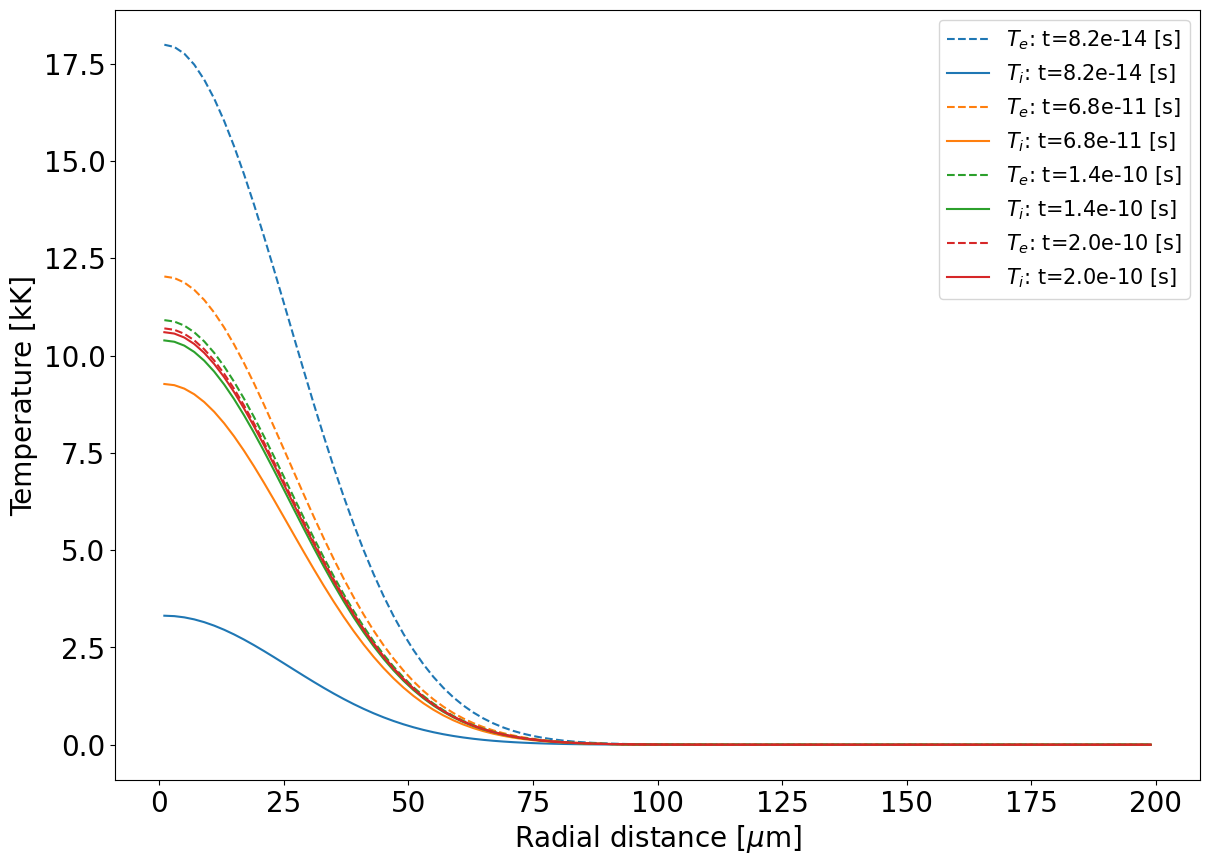

In [6]:
# Time integration loop
t = 0
plot_idx = 0
plot_times = np.linspace(dt,t_max/2,num=4,endpoint=True)  # Intermediate times for plotting
# plot_times = [dt, 2*dt]

t_list, Te_list, Ti_list = [0], [Te.copy()], [Ti.copy()]
fig, ax = plt.subplots(figsize=(14,10),facecolor='w')
while t < t_max:
    # Calculate new temperatures using explicit Euler method, finite volume, and relaxation
    Te_flux = ke(Te) * 2*π*r * grad_T(Te) #Cylindrical flux first order
    Ti_flux = ki(Ti) * 2*π*r * grad_T(Ti)
    
    # Note- γ is a CONSTANT!!! Broken to make it a function of r right now!
    Te_new = Te[:-1] + dt * (
        (Te_flux[1:] - Te_flux[:-1]) / cell_volumes
        - (γ(Te_init,Ti_init) * (Te - Ti))[:-1]
    )/Ce
    
    Ti_new = Ti[:-1] + dt * (
        (Ti_flux[1:] - Ti_flux[:-1]) / cell_volumes
        + (γ(Te_init,Ti_init) *(Te - Ti))[:-1]
    )/Ci

    # Update temperatures
    Te[:-1] = Te_new
    Ti[:-1] = Ti_new
    t += dt
    t_list.append(t); Te_list.append(Te.copy()); Ti_list.append(Ti.copy())
    
    # Plot temperature profiles at intermediate times
    if plot_idx < len(plot_times) and t >= plot_times[plot_idx]:
        ax.plot(cell_centers*1e6, Te[:-1]*1e-3, '--', color=colors[plot_idx], label=f"$T_e$: t={t:.1e} [s]")
        ax.plot(cell_centers*1e6, Ti[:-1]*1e-3, '-' , color=colors[plot_idx], label=f"$T_i$: t={t:.1e} [s]")
        plot_idx += 1

        
# Plot settings
ax.set_xlabel(r"Radial distance [$\mu$m]",fontsize=20)
ax.set_ylabel("Temperature [kK]",fontsize=20)
ax.tick_params(labelsize=20)
# ax.set_ylim(0,10.1)

ax.legend(fontsize=15)
plt.show()


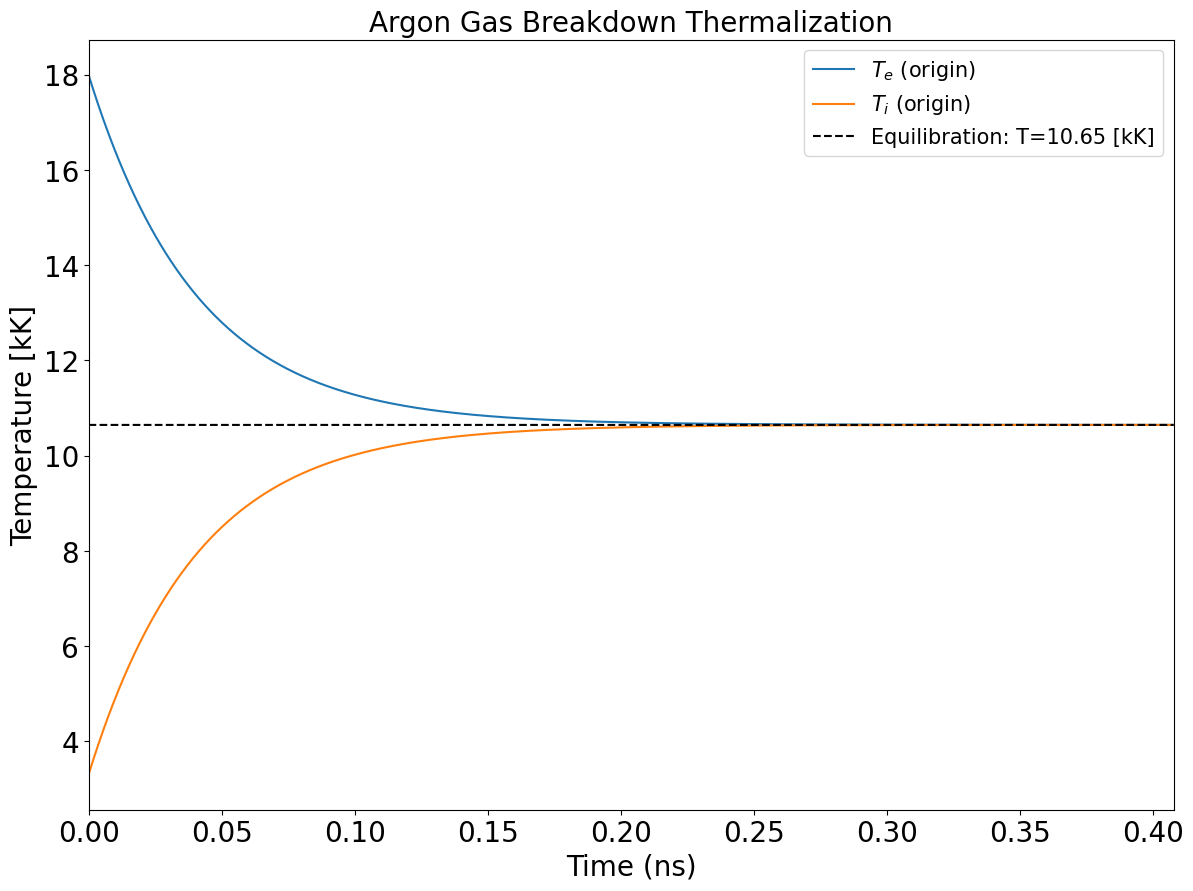

In [7]:
fig, ax = plt.subplots(figsize=(14,10),facecolor='w')

T_eq = Ti_list[-1][0]
ax.plot(np.array(t_list)*1e9, np.array(Te_list).T[0]*1e-3,label=r"$T_e$ (origin)")
ax.plot(np.array(t_list)*1e9, np.array(Ti_list).T[0]*1e-3,label=r"$T_i$ (origin)")
ax.plot(np.array(t_list)*1e9, np.ones(len(Ti_list))*T_eq*1e-3,'--k',label='Equilibration: T={0:.2f} [kK]'.format(T_eq*1e-3))

# Plot settings
ax.set_xlabel(r"Time (ns)", fontsize=20)
ax.set_ylabel("Temperature [kK]",fontsize=20)
ax.tick_params(labelsize=20)
ax.set_xlim(0,t_max*1e9)

ax.set_title('Argon Gas Breakdown Thermalization',fontsize=20)
ax.legend(fontsize=15)
plt.show()

In [8]:
Ti_list[-1][0],Te_list[-1][0]

(10645.942617077173, 10645.87554060358)